# Qlearning, SARSA

#### Imports

In [4]:
from typing import Dict, List, Tuple, Optional
from collections import namedtuple
import os

In [5]:
from functional import seq, pseq
from functional.streams import Sequence
from IPython.core.display import HTML

def display_seq(sequence:Sequence,rows:int)-> None:
        sequence._repr_html_= lambda :sequence.tabulate(rows,tablefmt='html')
        display(sequence)
        sequence._repr_html_= lambda :sequence.tabulate(10,tablefmt='html')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 8]

# Qlearn

I found best parameters by interating over possible values of `learning rate`, `epsilon` and `discount factor`

In [6]:
%%sh 
#tail -n 45 ../balance.py 

## Plotting reward for best params

In [7]:
%%sh
ls *.csv 

1.csv
2.csv
3.csv
4.csv
5.csv
chosen_1.csv
chosen_2.csv
chosen_3.csv
chosen_4.csv
chosen_5.csv
chosen_6.csv
chosen_fix_1.csv
chosen_fix_2.csv
chosen_fix_3.csv
chosen_fix_4.csv
chosen_fix_5.csv
chosen_fix_6.csv
sarsa_1.csv
sarsa_2.csv
sarsa_3.csv
sarsa_4.csv
sarsa_5.csv


In [8]:
trials= range(1,5 +1)
list(trials)

[1, 2, 3, 4, 5]

In [9]:
def to_pandas(aggregate,trial:int):
    if type(aggregate) == list:
        aggregate = seq(aggregate)
    
    d = aggregate.to_pandas(columns= ['params','iteration','reward'])
    d['moving_avg'] = d.reward.rolling(window= 10).mean()
    d['trial'] = trial
    return d

In [10]:
def build_df(param:int) -> pd.DataFrame:
    
    builder = []
    
    for trial in trials:
        t = pd.read_csv(f"{trial}.csv") 
#         t['moving_avg'] = t.rolling(window=10).mean()
        
        res = seq(t).group_by(lambda x:x[0])\
        .map(lambda prams_df: to_pandas(prams_df[1],trial).dropna()).to_list()
        
        builder = builder + res
    
    return pd.concat(builder) 

In [45]:
df = build_df(trials)

In [12]:
def create_avgs(df_for_param:pd.DataFrame):
    
    df_for_param = df_for_param[['iteration', 'moving_avg']].groupby(['iteration'],as_index=False).agg(['mean','std']).reset_index()
    df_for_param['mean'] = df_for_param['moving_avg','mean']
    df_for_param['std'] = df_for_param['moving_avg','std']
    df_for_param = df_for_param.drop(columns= 'moving_avg')
    return df_for_param
    
#     to_plot = d.copy()
#     to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
#     to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    

In [46]:
dfs = seq(df).group_by(lambda x: x[0]).map(lambda x: (x[0],create_avgs(seq(x[1]).to_pandas(columns=["params","iteration","reward","moving_avg","trial"]))))

In [ ]:
# dfs.filter(lambda x: x[1]['mean'].max() > 320).size()

In [47]:
maxes = dfs.order_by(lambda x: - x[1]['mean'].max() ).take(n=10).cache()
# maxes = dfs.filter(lambda x: x[1]['mean'].max() > 320)

/home/owner/.local/lib/python3.8/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


In [48]:
maxes.map(lambda x: x[1]['mean'].max())

[60.120000000000005, 57.3, 56.04, 55.379999999999995, 54.959999999999994, 54.18000000000001, 53.44000000000001, 53.160000000000004, 52.18000000000001, 51.4]

In [25]:
def present(x:Tuple[str,pd.DataFrame]):
    to_plot = x[1].copy()
    to_plot['minus_std'] = to_plot['mean'] - to_plot['std']
    to_plot['plus_std'] = to_plot['mean'] + to_plot['std']
    
    to_plot = to_plot[['mean','plus_std','minus_std']]
#     display(HTML(x[0]))

    title=x[0]
    t = title.split("|")
    if float(t[-1]) > 1:
        bucket = t[-1][0]
        decay = t[-1][1:]
        t= t[:-1] + [bucket,decay]
        title = "|".join(t)

    to_plot.plot(title= title)


0.2 0.1 0.7 4

0.2 0.1 0.7 4

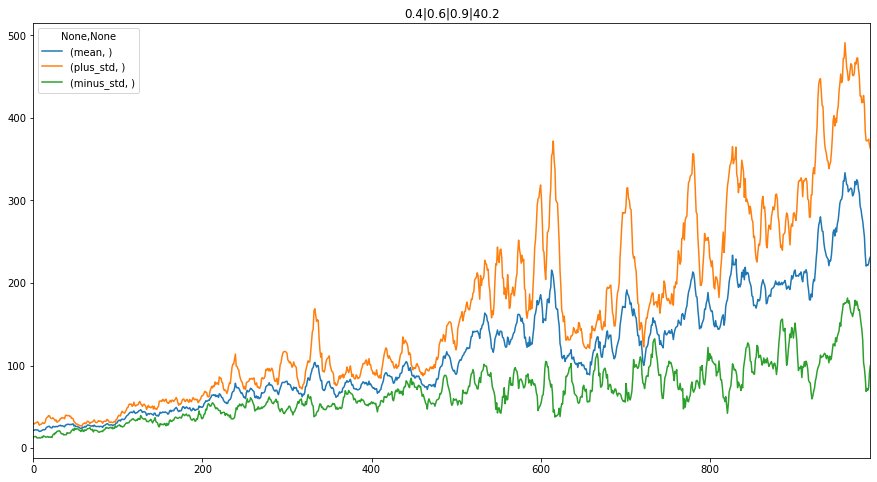

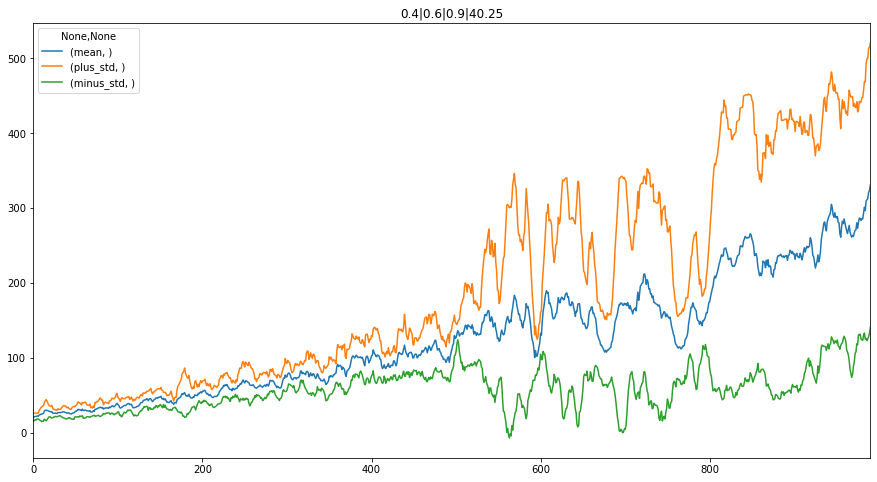

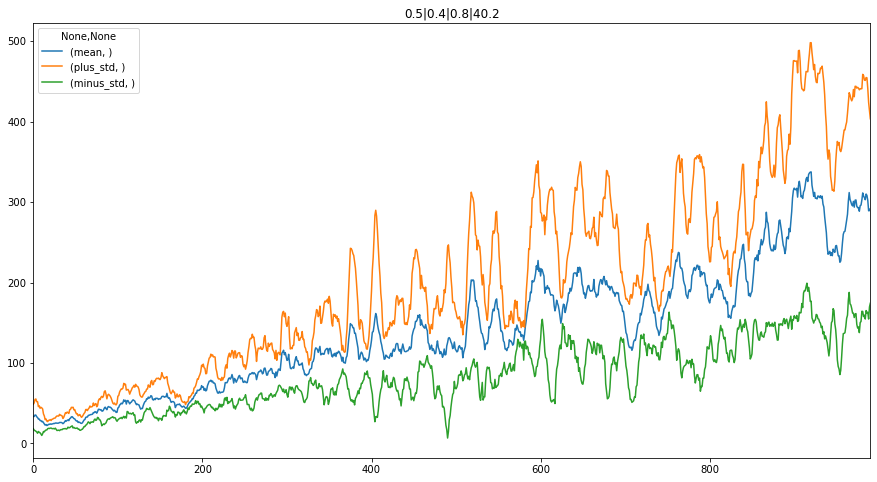

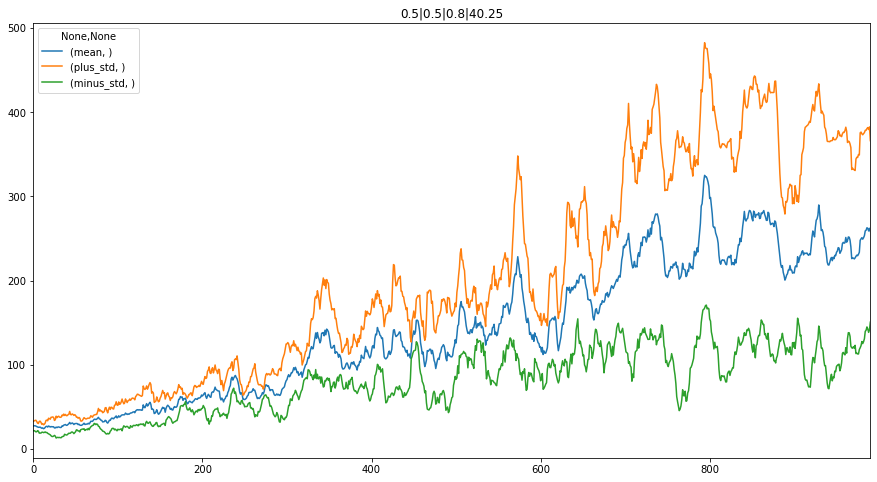

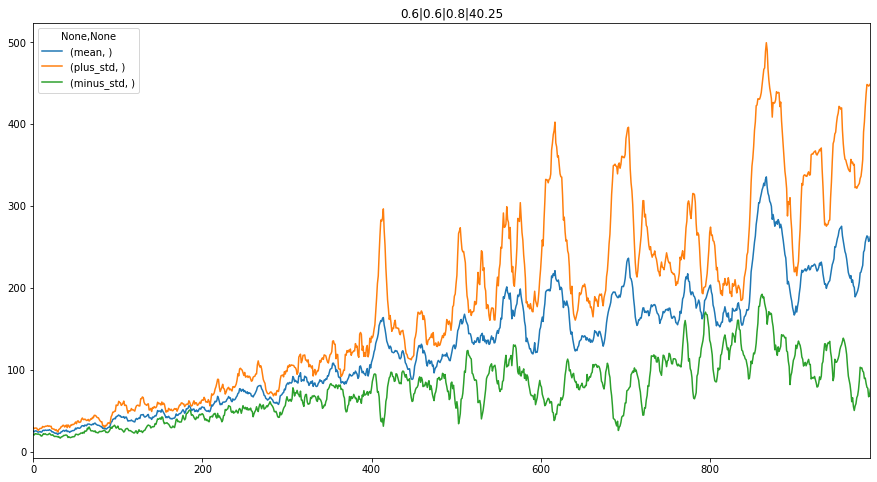

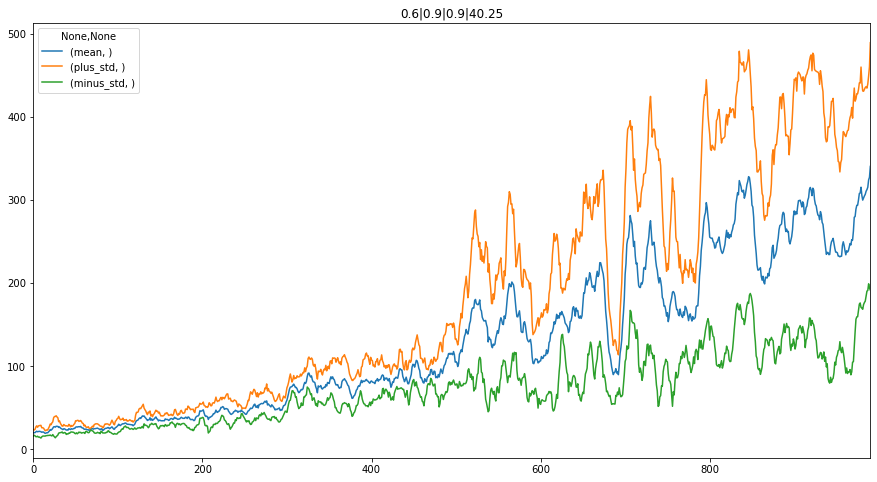

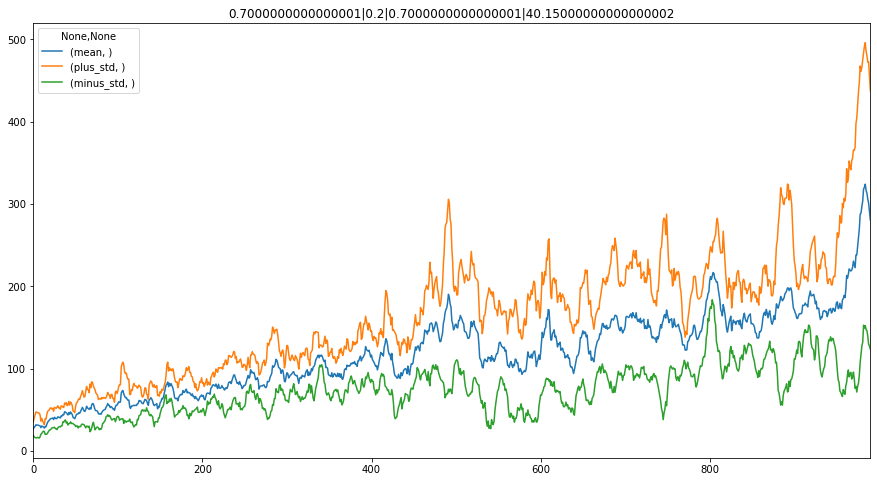

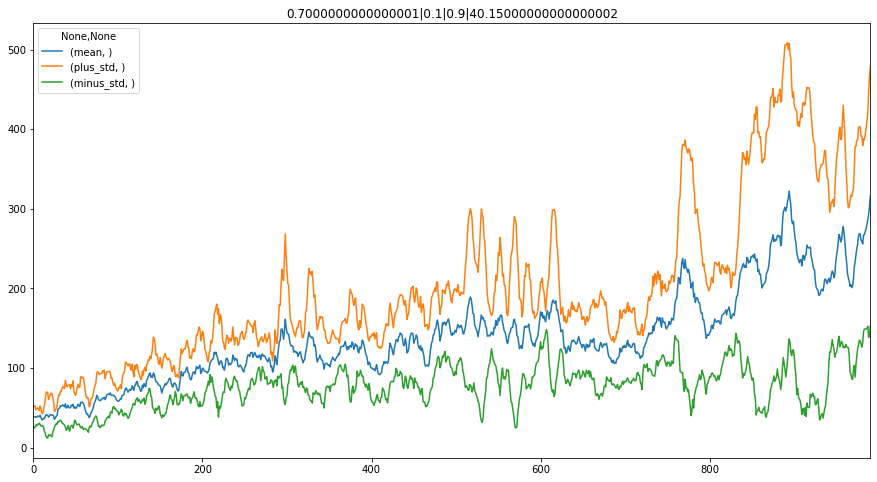

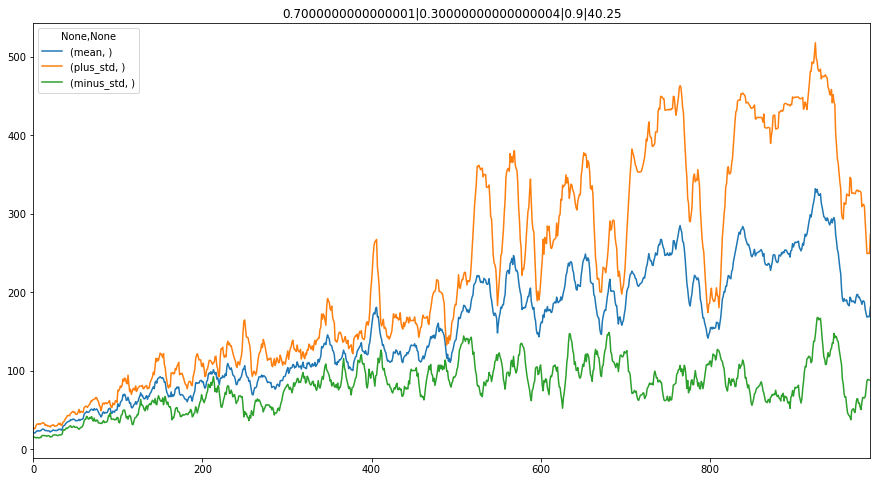

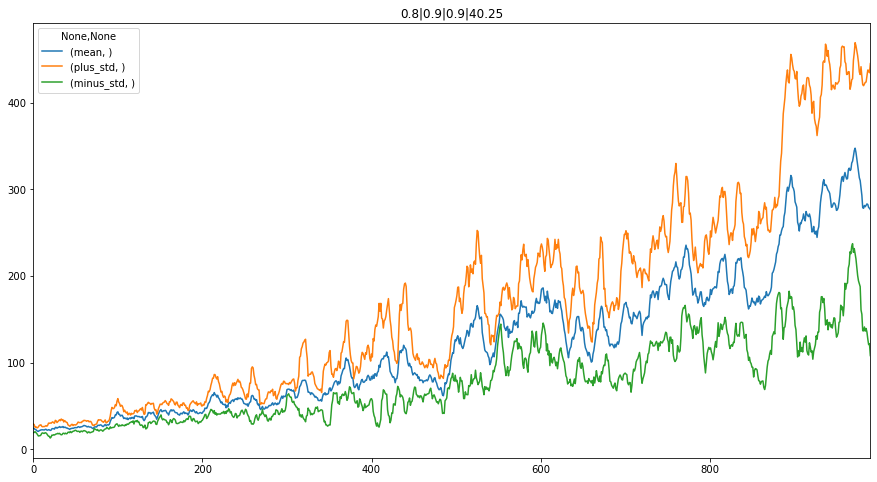

In [20]:
display(HTML("<h3>LearningRate | eps | discount_factor | buckets</h3>"))
maxes.for_each(present)

## Longer runs Of Qlearn

## Choosen params
| lr  | eps | discount_factor  | buckets | decay |
|-----|-----|------------------|---------|-------|
| 0.8 | 0.9 | 0.9              | 4       | 0.25  |
| 0.6 | 0.9 | 0.9              | 4       | 0.25  |
| 0.5 | 0.5 | 0.8              | 4       | 0.25  |
| 0.4 | 0.6 | 0.9              | 4       | 0.25  |

In [48]:
%%sh
for  i in $(seq 1 6);do
    cat chosen_${i}.csv | awk '/reward/{if(NR ==1){print $0}; next} {print}' > chosen_fix_${i}.csv
done

In [49]:
def build_choosen(param:int) -> pd.DataFrame:
    
    builder = []
    
    for trial in trials:
        t = pd.read_csv(f"chosen_fix_{trial}.csv") 
#         t['moving_avg'] = t.rolling(window=10).mean()
        
        res = seq(t).group_by(lambda x:x[0])\
        .map(lambda prams_df: to_pandas(prams_df[1],trial).dropna()).to_list()
        
        builder = builder + res
    
    return pd.concat(builder) 

In [51]:
chosen_df= build_choosen([1])
chosen = seq(build_choosen(trials))\
.group_by(lambda x: x[0])\
.map(lambda x: 
     (
         x[0],
         create_avgs(seq(x[1]).to_pandas(columns=["params","iteration","reward","moving_avg","trial"]))
     )
    )

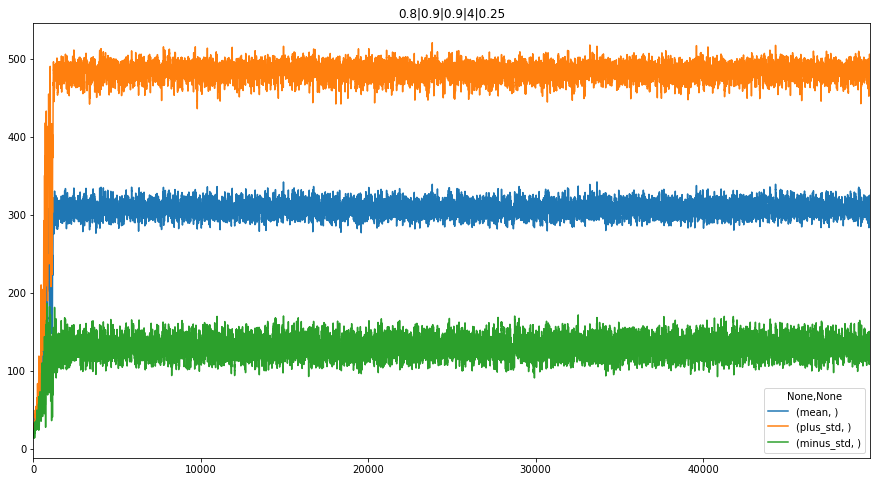

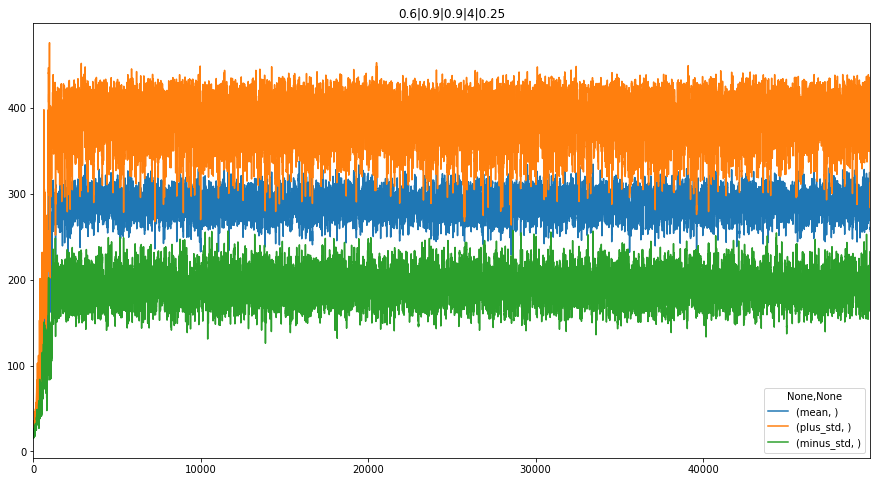

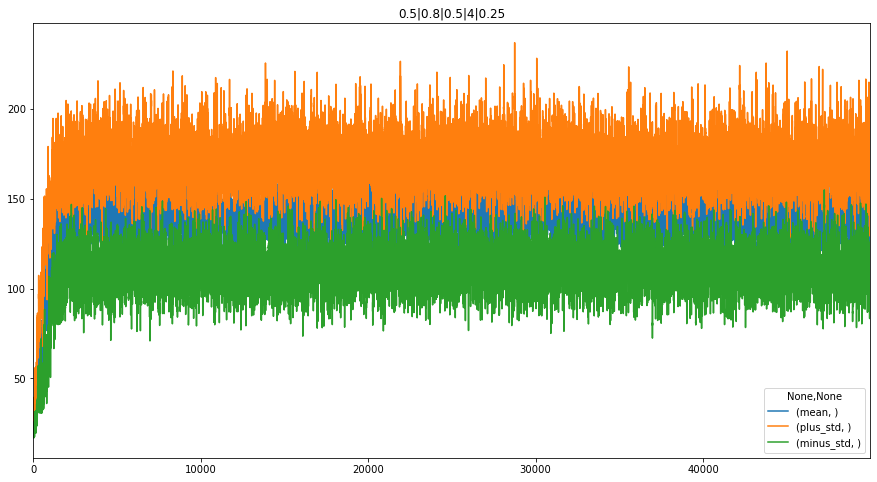

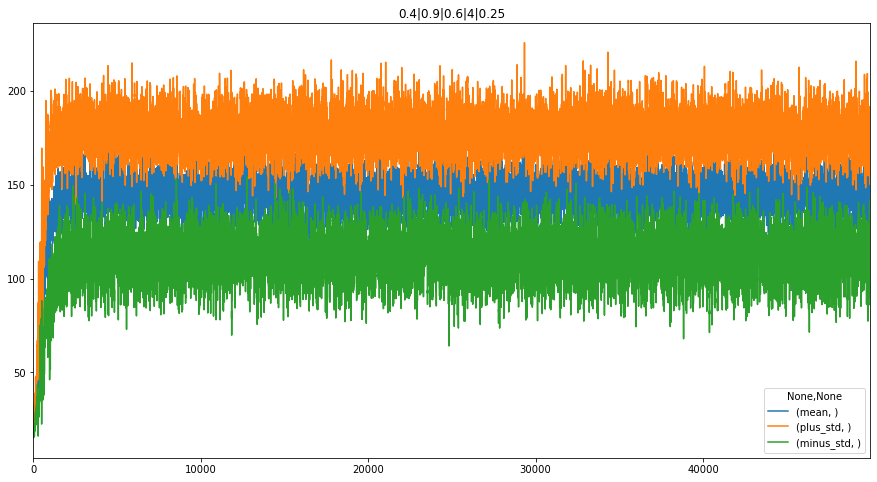

In [52]:
chosen.for_each(present)

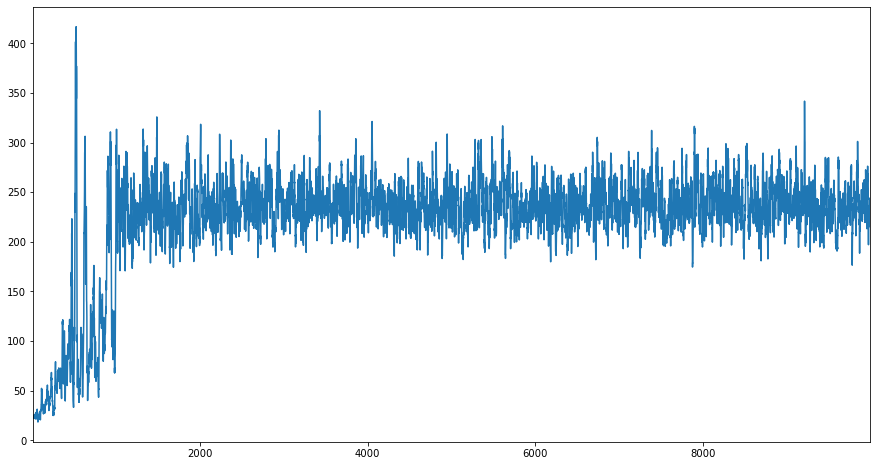

In [44]:
t = to_pandas(seq(pd.read_csv(f"a_1.csv") ),1).dropna()

t['moving_avg'].plot()

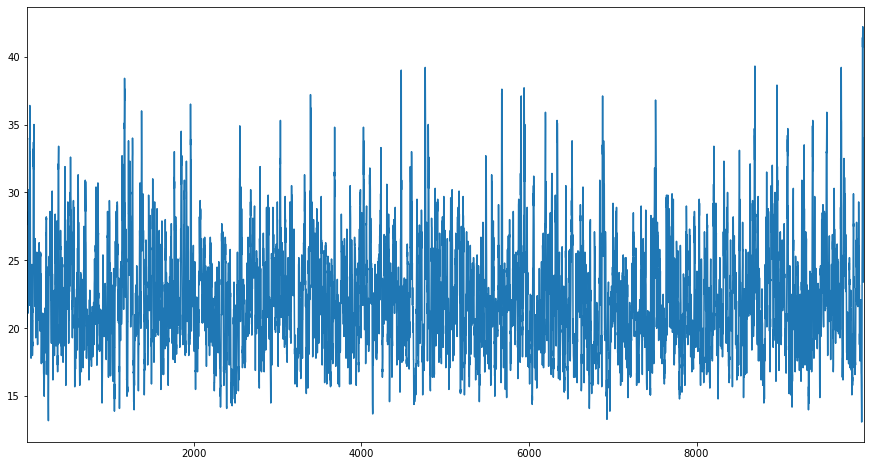

In [40]:
chosen_sarsa = seq(build_choosen_sarsa(trials))\
.group_by(lambda x: x[0])\
.map(lambda x: 
     (
         x[0],
         create_avgs(seq(x[1]).to_pandas(columns=["params","iteration","reward","moving_avg","trial"]))
     )
    )

/home/owner/.local/lib/python3.8/site-packages/pandas/core/generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


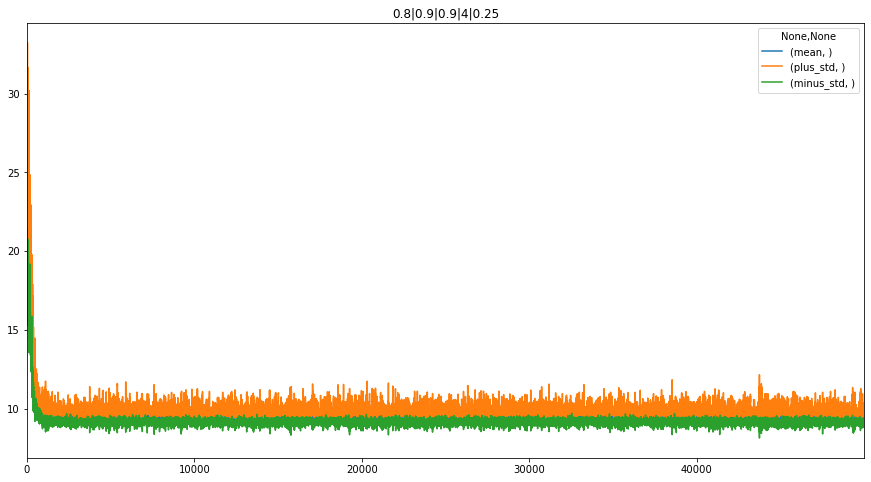

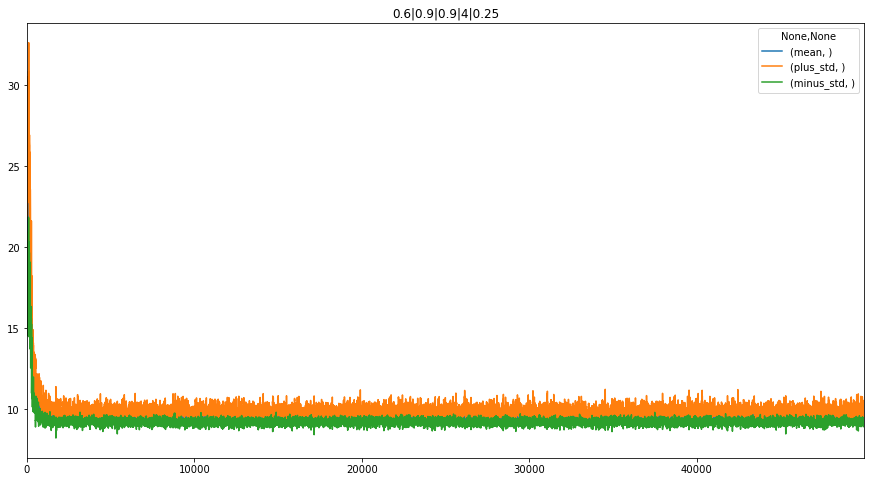

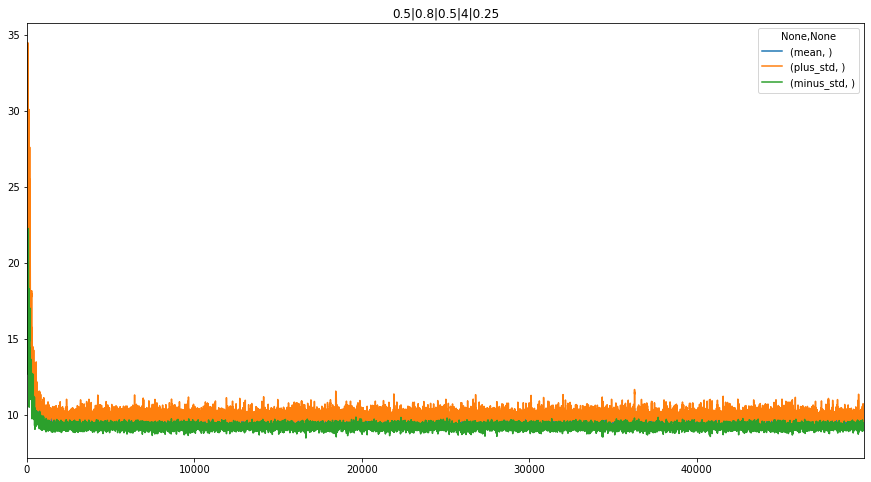

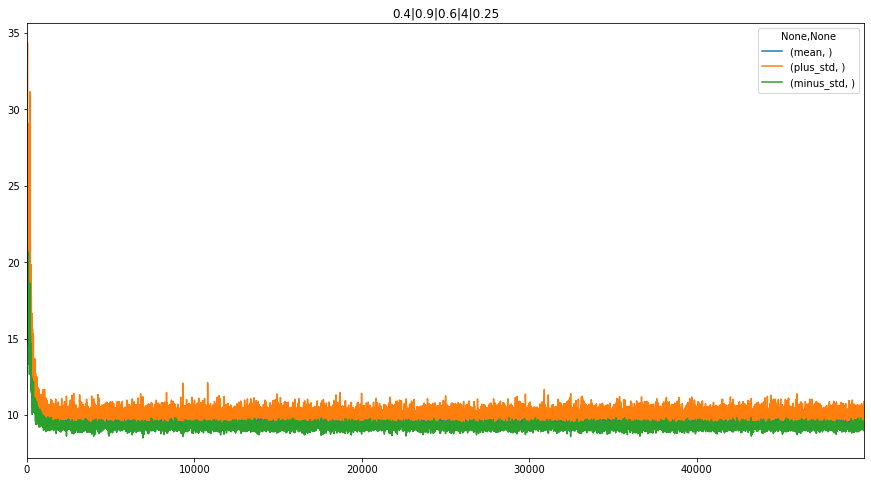

In [41]:
chosen_sarsa.for_each(present)